# VLM Qualitative & Quantitative Inference

Evaluation of the trained VLM model using the Qwen 2.5 3B backbone.
This notebook includes:
1. Model Loading (Vision Encoder + Qwen Decoder)
2. Quantitative Evaluation (Exact Match, F1 Score) on Validation Set
3. Qualitative Inference (Interactive & Random Sampling)

In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
print(Path.cwd().parent)
sys.path.insert(0, str(Path.cwd().parent))
import os
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Force single GPU to avoid mismatches


/storage/ice1/1/0/vchopra37/projects/edge_glass/edge_glass_modular


In [3]:

import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

# Add src to path
project_root = Path(os.path.abspath('..'))
sys.path.append(str(project_root))
sys.path.append(str(project_root / "src"))

from config import load_config
from models.alignment import MultimodalAlignmentModel
from models.trm_qwen_vlm import QwenVLM
from decoders.qwen import QwenDecoder
from data.transforms import get_image_transforms
from data.dataset_builder import PixmoQADataset

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Using device: cuda


In [4]:
# Added manual metrics
from src.evaluation.simple_metrics import compute_bleu, compute_rouge_l, compute_perplexity

In [5]:
# --- Configuration ---
config_path = "../configs/trm_vlm_qa_qwen2.5-3b_regularized.yaml"
alignment_config_path = "../configs/pixmo_alignment.yaml"

# Checkpoints - Update these as needed
# Default to looking for 'checkpoint_best' in the output directory defined in config, or override here
# Checkpoints
# Auto-detect latest checkpoint
import glob

output_dir = Path("../outputs/trm_vlm_qa_3b_reg")
epoch_checkpoints = sorted(output_dir.glob("checkpoint-epoch-*"), key=lambda p: int(str(p).split('-')[-1]))

if epoch_checkpoints:
    checkpoint_dir = str(epoch_checkpoints[-1])
    print(f"Auto-detected latest checkpoint: {checkpoint_dir}")
else:
    # Fallback
    checkpoint_dir = str(output_dir / "checkpoint_best")
    print(f"No epoch checkpoints found. Using: {checkpoint_dir}")
alignment_checkpoint = "../notebooks/checkpoints/pixmo_alignment/checkpoint_best.pt"

use_trm = True

# --- Load Models ---
print("Loading Models...")

# 1. Vision Encoder (Aligned)
print("Loading Vision Encoder...")
alignment_config = load_config(alignment_config_path)
alignment_config.decoder = None
alignment_config.text_encoder = None
aligned_model = MultimodalAlignmentModel(alignment_config)

if os.path.exists(alignment_checkpoint):
    print(f"Loading alignment checkpoint from {alignment_checkpoint}")
    ckpt = torch.load(alignment_checkpoint, map_location='cpu', weights_only=False)
    aligned_model.load_state_dict(ckpt['model_state_dict'], strict=False)
else:
    print(f"WARNING: Alignment checkpoint not found at {alignment_checkpoint}")

aligned_model.eval().to(device)
# Freeze vision encoder
for param in aligned_model.parameters():
    param.requires_grad = False

# 2. VLM (Qwen Decoder + Projection)
print("Loading VLM...")
config = load_config(config_path)
# Force single-device map to avoid cross-GPU splits during inference
qwen_decoder = QwenDecoder(
    config.decoder.model_name,
    load_in_4bit=config.decoder.load_in_4bit, 
    use_lora=config.decoder.use_lora, 
    device_map=None # Disable auto-map to prevent sharding errors on single node
)


model = QwenVLM(
    qwen_decoder, 
    alignment_config.vision_encoder.projection_dim,
    use_trm_recursion=use_trm, 
    num_trm_layers=4, 
    num_recursion_steps=4
).to(device)

# Load VLM Checkpoint
if os.path.isdir(checkpoint_dir):
    # Check for safe tensors or bin
    print(f"Loading VLM checkpoint from directory: {checkpoint_dir}")
    # If using PEFT/LoRA, we might need to load adapters. 
    # However, if we trained with full state dict saving (which we did in the script), we might have a full state dict.
    # Let's check for standard pytorch_model.bin or adapter_model.bin
    
    # Try loading as a full state dict first if it exists (non-LoRA or full save)
    bin_path = Path(checkpoint_dir) / "pytorch_model.bin"
    if bin_path.exists():
        print("Found pytorch_model.bin, loading...")
        state_dict = torch.load(bin_path, map_location='cpu')
        model.load_state_dict(state_dict, strict=False)
    else:
        # If strictly LoRA adapters are saved via save_pretrained
        # The model logic in QwenVLM wraps the decoder. 
        # If the checkpoint is just adapters, we might need `qwen_decoder.model.load_adapter(...)` or similar if using peft.
        # But our training script saves uses `accelerator.save_state` or `save_model`.
        # `save_model` with DeepSpeed usually saves full weights or shards.
        # Let's assume standard loading works for now, or fallback to PEFT load if needed.
        print("No standard pytorch_model.bin found. Assuming PEFT/DeepSpeed layout or checking for adapter_model.bin...")
        try:
             from peft import PeftModel
             if (Path(checkpoint_dir) / "adapter_model.bin").exists() or (Path(checkpoint_dir) / "adapter_model.safetensors").exists():
                 print("Found adapter model, loading adapters...")
                 model.qwen_decoder.model = PeftModel.from_pretrained(model.qwen_decoder.model, checkpoint_dir)
        except Exception as e:
             print(f"Could not load adapters: {e}")

else:
    # Single file checkpoint
    if os.path.exists(checkpoint_dir):
        print(f"Loading VLM checkpoint from file: {checkpoint_dir}")
        model.load_state_dict(torch.load(checkpoint_dir, map_location='cpu')['model_state_dict'], strict=False)
    else:
        print(f"WARNING: Checkpoint {checkpoint_dir} does not exist. Using random init (or pretrained base).")

model.eval()
print("Model Ready!")

Auto-detected latest checkpoint: ../outputs/trm_vlm_qa_3b_reg/checkpoint-epoch-2
Loading Models...
Loading Vision Encoder...
Loading alignment checkpoint from ../notebooks/checkpoints/pixmo_alignment/checkpoint_best.pt
Loading VLM...
DEBUG: Initial config num_key_value_heads: 2
DEBUG: Final config num_key_value_heads: 2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 14,745,600 || all params: 3,100,684,288 || trainable%: 0.4756
Loading VLM checkpoint from directory: ../outputs/trm_vlm_qa_3b_reg/checkpoint-epoch-2
No standard pytorch_model.bin found. Assuming PEFT/DeepSpeed layout or checking for adapter_model.bin...
Model Ready!


## 2. Quantitative Evaluation
Compute Exact Match (EM) and F1 Score on the validation set.

In [6]:
# import string
# import re
# from collections import Counter

# def normalize_answer(s):
#     """Lower text and remove punctuation, articles and extra whitespace."""
#     def remove_articles(text):
#         return re.sub(r'\b(a|an|the)\b', ' ', text)

#     def white_space_fix(text):
#         return ' '.join(text.split())

#     def remove_punc(text):
#         exclude = set(string.punctuation)
#         return ''.join(ch for ch in text if ch not in exclude)

#     def lower(text):
#         return text.lower()

#     return white_space_fix(remove_articles(remove_punc(lower(s))))

# def compute_exact_match(prediction, truth):
#     return int(normalize_answer(prediction) == normalize_answer(truth))

# def compute_f1(prediction, truth):
#     pred_tokens = normalize_answer(prediction).split()
#     truth_tokens = normalize_answer(truth).split()
    
#     # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
#     if len(pred_tokens) == 0 or len(truth_tokens) == 0:
#         return int(pred_tokens == truth_tokens)
    
#     common = Counter(pred_tokens) & Counter(truth_tokens)
#     num_same = sum(common.values())
    
#     if num_same == 0:
#         return 0
    
#     precision = 1.0 * num_same / len(pred_tokens)
#     recall = 1.0 * num_same / len(truth_tokens)
#     f1 = (2 * precision * recall) / (precision + recall)
#     return f1

In [7]:
# def evaluate_dataset(max_samples=None):
#     scores = {'params': [], 'f1': [], 'em': [], 'bleu': [], 'rouge': []}
#     count = 0
    
#     print(f"Starting evaluation (Max samples: {max_samples if max_samples else 'All'})...")
    
#     # Detect model device
#     if hasattr(model.qwen.model, "device"):
#          model_device = model.qwen.model.device 
#     else:
#          model_device = next(model.parameters()).device
    
#     enc_device = aligned_model.vision_encoder.device if hasattr(aligned_model.vision_encoder, 'device') else next(aligned_model.vision_encoder.parameters()).device

#     for batch in tqdm(val_loader):
#         for item in batch:
#             if item is None: continue
            
#             image = item['image'].unsqueeze(0).to(enc_device)
#             question_ids = item['question_ids'].unsqueeze(0).to(model_device)
#             ground_truth = item['answer']
            
#             # Encode Vision
#             with torch.no_grad():
#                 vision_tokens = aligned_model.vision_encoder(image, return_sequence=True).sequence
#                 vision_tokens = vision_tokens.to(model_device)
            
#             # Generate Answer
#             with torch.no_grad():
#                 gen_ids = model.generate(
#                     vision_tokens=vision_tokens,
#                     question_ids=question_ids,
#                     max_new_tokens=64,
#                     temperature=0.0, # Greedy for evaluation
#                     do_sample=False
#                 )
            
#             # Decode
#             predicted_answer = qwen_decoder.tokenizer.decode(gen_ids[0], skip_special_tokens=True)
            
#             # Compute Metrics
#             em = compute_exact_match(predicted_answer, ground_truth)
#             f1 = compute_f1(predicted_answer, ground_truth)
#             bleu = compute_bleu(ground_truth, predicted_answer)
#             rouge = compute_rouge_l(ground_truth, predicted_answer)
            
#             scores['em'].append(em)
#             scores['f1'].append(f1)
#             scores['bleu'].append(bleu)
#             scores['rouge'].append(rouge)
            
#             count += 1
#             if max_samples and count >= max_samples:
#                 break
        
#         if max_samples and count >= max_samples:
#             break
            
#     avg_em = sum(scores['em']) / len(scores['em'])
#     avg_f1 = sum(scores['f1']) / len(scores['f1'])
#     avg_bleu = sum(scores['bleu']) / len(scores['bleu'])
#     avg_rouge = sum(scores['rouge']) / len(scores['rouge'])
    
#     print(f"\nResults ({count} samples):")
#     print(f"Average EM: {avg_em:.4f}")
#     print(f"Average F1: {avg_f1:.4f}")
#     print(f"Average BLEU-4: {avg_bleu:.4f}")
#     print(f"Average ROUGE-L: {avg_rouge:.4f}")
#     return avg_em, avg_f1, avg_bleu, avg_rouge
    
# # Run small eval to test
# evaluate_dataset(max_samples=20)


## 3. Qualitative Evaluation (Interactive)

In [8]:
# --- Validation dataset for qualitative checks ---
print("Loading validation dataset for qualitative checks...")
val_dataset = PixmoQADataset(
    parquet_path=config.dataset.val_parquet,
    tokenizer=qwen_decoder.tokenizer,
    image_transforms=get_image_transforms(config.dataset.image_size, is_training=False),
    max_question_length=config.dataset.max_question_length,
    max_answer_length=config.dataset.max_answer_length,
)
print(f"Validation samples: {len(val_dataset)}")


Loading validation dataset for qualitative checks...
Loaded 1800 samples from /home/hice1/vchopra37/scratch/projects/edge_glass/dataset/final_dataset/pixmo_alignment/pixmo_qa_mixed_val.parquet
Validation samples: 1800


Running a single random sample check...
Q: [USER]Are there piles of white dirt or powder visible on the far side of the water?
[ASSISTANT]
GT: Yes


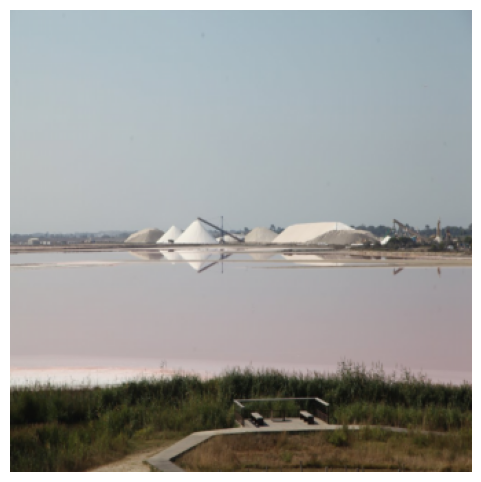

🤖 Model Answer:  It looks like it seems that the code is be translated to English. It looks like It looks like It code is code that code is code looks like it code looks like it code
✅ Ground Truth: Yes
Error: name 'compute_f1' is not defined


Traceback (most recent call last):
  File "/home/hice1/vchopra37/scratch/models/tmp/ipykernel_4000561/1396251465.py", line 60, in run_inference
    f1 = compute_f1(answer, ground_truth)
         ^^^^^^^^^^
NameError: name 'compute_f1' is not defined. Did you mean: 'compute_bleu'?


In [9]:
def run_inference(image_source, question, ground_truth=None):
    """
    Runs inference on an image path or PIL image.
    """
    # Load and Plot Image
    try:
        if isinstance(image_source, str) or isinstance(image_source, Path):
            image = Image.open(image_source).convert('RGB')
        else:
            image = image_source # Allow passing PIL object directly
            
        plt.figure(figsize=(6,6))
        plt.imshow(image)
        plt.axis('off')
        title = f"Q: {question}"
        if ground_truth:
            title += f"\nGT: {ground_truth}"
        # plt.title(title)
        print(title)
        plt.show()
        
        # Use a single, fixed device to avoid cross-GPU tensor issues
        model_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        if model_device.type == 'cuda':
            torch.cuda.set_device(torch.cuda.current_device())
        
        # Transform
        transform = get_image_transforms(config.dataset.image_size, is_training=False)
        # Validate tensor device
        img_tensor = transform(image).unsqueeze(0).to(model_device)
        
        # Encode
        with torch.no_grad():
            # Ensure aligned encoder inputs are on its device
            enc_device = aligned_model.vision_encoder.device if hasattr(aligned_model.vision_encoder, 'device') else next(aligned_model.vision_encoder.parameters()).device
            vision_tokens = aligned_model.vision_encoder(img_tensor.to(enc_device), return_sequence=True).sequence
            
        # Generate
        # Ensure inputs are on model device
        inputs = qwen_decoder.tokenizer([question], return_tensors='pt', padding=True).to(model_device)
        
        # Vision tokens need to be on the same device as inputs for the model forward usually, 
        # but QwenVLM.generate might handle projection. Let's force vision_tokens to model_device just in case.
        vision_tokens = vision_tokens.to(model_device)
        
        with torch.no_grad():
            gen_ids = model.generate(
                vision_tokens=vision_tokens,
                question_ids=inputs.input_ids,
                max_new_tokens=36,
                temperature=0.2, # Slight temp for variety in qualitative
                do_sample=True
            )
        
        answer = qwen_decoder.tokenizer.decode(gen_ids[0], skip_special_tokens=True)
        print(f"🤖 Model Answer: {answer}")
        if ground_truth:
             print(f"✅ Ground Truth: {ground_truth}")
             # Metrics
             f1 = compute_f1(answer, ground_truth)
             em = compute_exact_match(answer, ground_truth)
             bleu = compute_bleu(ground_truth, answer)
             rouge = compute_rouge_l(ground_truth, answer)
             print(f"F1: {f1:.2f} | EM: {em} | BLEU-4: {bleu:.2f} | ROUGE-L: {rouge:.2f}")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

# Interactive Helper
def check_random_sample(dataset):
    idx = np.random.randint(0, len(dataset))
    item = dataset[idx]

    # Better approach for qualitative: Inverse transform the tensor to show it
    img_tensor = item['image']
    # Un-normalize (approximate standard mean/std for CLIP/SigLIP usually)
    # Assuming CLIP mean/std
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
    img = img_tensor * std + mean
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    
    # Convert to PIL for the function
    pil_img = Image.fromarray((img * 255).astype(np.uint8))
    
    q_text = qwen_decoder.tokenizer.decode(item['question_ids'], skip_special_tokens=True)
    a_text = item['answer']
    
    run_inference(pil_img, q_text, ground_truth=a_text)

print("Running a single random sample check...")
check_random_sample(val_dataset)


Q: Describe what is this ?.


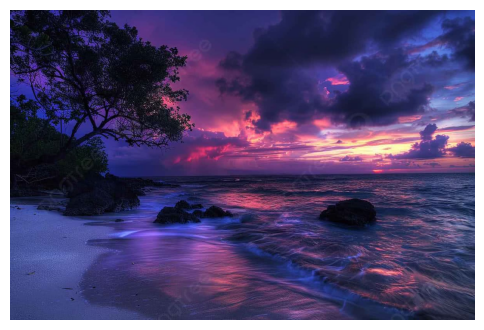

🤖 Model Answer:  It is a picture of a picture. It is a picture of a picture. It is a picture of a picture. It is a picture of a picture. It is a picture


In [11]:
# --- Quick inference on a custom image ---
custom_image_path = "/home/hice1/vchopra37/scratch/projects/edge_glass/temp.jpg"
custom_question = "Describe what is this ?."
run_inference(custom_image_path, custom_question)
